Inspired by a course from Yale (ECON 159, Lecture 3, https://oyc.yale.edu/economics/econ-159/lecture-3), this post explores the median voter theorem through a simple computational experiment, and expand based on that.

The median voter theorem states that when voters and candidates can be placed along a single left-to-right line (a one-dimensional ideological spectrum), and voters prefer candidates who are closer to their own position, the winning candidate will be the one closest to the voter at the median of the population, considering the voting rule respects majority decisions.

As a starting point, we consider the simplest possible case: voters are evenly distributed along the spectrum, and there are only two candidates. We then simulate how candidates choose their positions and examine whether the resulting outcome is indeed dominated by the median voter.

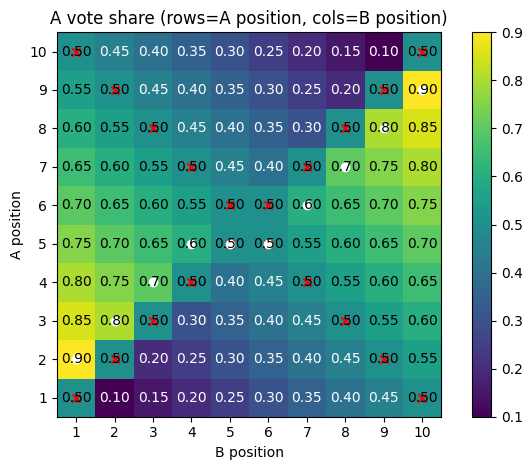

Best response of A to each B position:
  If B=1, A best is 2 (A_share=0.9)
  If B=2, A best is 3 (A_share=0.8)
  If B=3, A best is 4 (A_share=0.7)
  If B=4, A best is 5 (A_share=0.6)
  If B=5, A best is 5 (A_share=0.5)
  If B=6, A best is 5 (A_share=0.5)
  If B=7, A best is 6 (A_share=0.6000000000000001)
  If B=8, A best is 7 (A_share=0.7000000000000001)
  If B=9, A best is 8 (A_share=0.8)
  If B=10, A best is 9 (A_share=0.9)


In [20]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Setting
# ----------------------------
positions = np.arange(1, 11)          # The candicate can select position from 1..10
voters = np.arange(1, 11)             # Voter positions from 1..10 uniformly
weights = np.ones_like(voters, float) # Number of voters at each position (uniform)
weights = weights / weights.sum()     # Normalize to sum to 1

# ----------------------------
# Calculation
# ----------------------------
A_share = np.zeros((10, 10), float)  # Rows: A position, Cols: B position
B_share = np.zeros((10, 10), float)

for i, a in enumerate(positions):
    for j, b in enumerate(positions):
        da = np.abs(voters - a) # Distance between voters and A, array
        db = np.abs(voters - b)

        A_votes = (da < db).astype(float) # Boolean array to float: 1 if A closer, else 0
        tie = (da == db) # Boolean array for ties
        A_votes[tie] = 0.5 # The score for ties is 0.5 for A

        A_share[i, j] = np.sum(weights * A_votes) # Weighted sum to get A's vote share
        B_share[i, j] = 1.0 - A_share[i, j]

# ----------------------------
# Calculate advantage for A
# ----------------------------
# For each B position (columns), find the A position (row) that gives max A_share
best_resp_A = np.argmax(A_share, axis=0)  

# ----------------------------
# Visualization
# ----------------------------
def heatmap(mat, title, xlabel="B position", ylabel="A position"):
    plt.figure()
    plt.imshow(mat, origin="lower", aspect="equal")
    plt.colorbar()
    plt.xticks(range(10), positions)
    plt.yticks(range(10), positions)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()

# Heatmap of A's share
heatmap(A_share, "A vote share (rows=A position, cols=B position)")

# Label all the tie positions in the plot where score is 0.5, it should also be a array with shape (positions, positions)
ties = np.zeros((len(positions), len(positions)), float)
for j, b in enumerate(positions):
    for i, a in enumerate(positions):
        da = np.abs(voters - a)
        db = np.abs(voters - b)

        A_votes = (da < db).astype(float)
        tie = (da == db)
        A_votes[tie] = 0.5

        score = np.sum(w * A_votes)
        if score == 0.5:
            ties[i, j] = 1

# Plot best responses of A on A's share heatmap
plt.plot(np.arange(10), best_resp_A, color="white", marker="o", linestyle="None")

# Mark tie positions
tie_positions = np.argwhere(ties == 1)
plt.scatter(tie_positions[:, 1], tie_positions[:, 0], marker="x", color="red", label="Ties (0.5 score)")

# Label the score in the heatmap
for i in range(len(positions)):
    for j in range(len(positions)):
        plt.text(j, i, f"{A_share[i, j]:.2f}", ha="center", va="center", color="white" if A_share[i, j] < 0.5 else "black")
        
        
plt.tight_layout()
plt.show()

# ----------------------------
# Print Results
# ----------------------------
print("Best response of A to each B position:")
for bpos, ai in zip(positions, best_resp_A):
    print(f"  If B={bpos}, A best is {positions[ai]} (A_share={A_share[ai, bpos-1]})")


Conclusion:
1. Best responses move towards 5 from both sides.
2. The median position is strategically stable, but not dominant (if it is dominant, that would mean no matter what B select, choose position 5 would give A as many vote as other position, which is not the case, for example, when B select 1 and A select 2)

Now comes the fun part. The setup above describes the simplest possible scenerio, but there are many directions we can go to explore. For example, what would happen if voters are not evenly distributed but left-skewed distribution, bimodel (polarized) distribution or gaussian? 

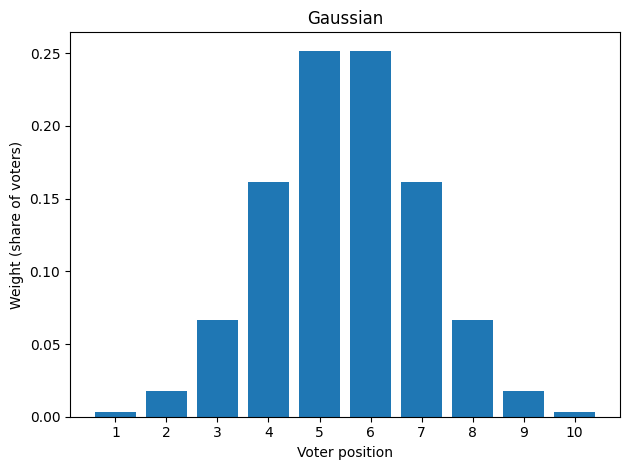

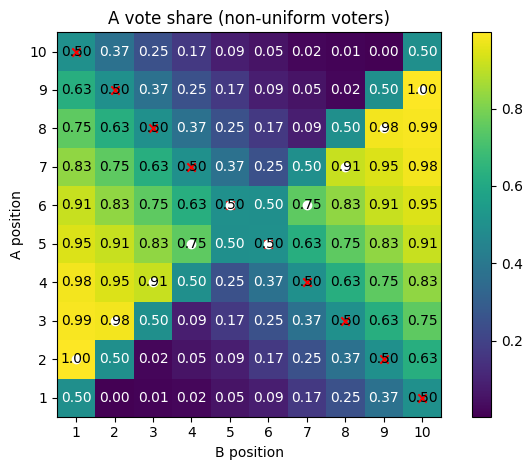

In [29]:
import numpy as np
import matplotlib.pyplot as plt

positions = np.arange(1, 11)
voters = positions.copy()

def normalize(w):
    w = np.asarray(w, float)
    return w / w.sum()

def weights_uniform():
    return normalize(np.ones_like(voters, float))

def weights_gaussian(mu=5.0, sigma=1.5):
    w = np.exp(-0.5 * ((voters - mu) / sigma) ** 2)
    return normalize(w)

def weights_bimodal(mu1=3.0, mu2=8.0, sigma=1.0, mix=0.5):
    w1 = np.exp(-0.5 * ((voters - mu1) / sigma) ** 2)
    w2 = np.exp(-0.5 * ((voters - mu2) / sigma) ** 2)
    w = mix * w1 + (1 - mix) * w2
    return normalize(w)

def two_candidate_Ashare(weights):
    A_share = np.zeros((len(positions), len(positions)), float)
    for i, a in enumerate(positions):
        for j, b in enumerate(positions):
            da = np.abs(voters - a)
            db = np.abs(voters - b)

            A_votes = (da < db).astype(float)
            tie = (da == db)
            A_votes[tie] = 0.5

            A_share[i, j] = np.sum(weights * A_votes)
    return A_share

def heatmap(mat, title, xlabel="B position", ylabel="A position"):
    plt.figure()
    plt.imshow(mat, origin="lower", aspect="equal")
    plt.colorbar()
    plt.xticks(range(len(positions)), positions)
    plt.yticks(range(len(positions)), positions)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()

def plot_voter_distribution(weights, title="Voter distribution"):
    plt.figure()
    plt.bar(voters, weights)
    plt.xticks(voters)
    plt.xlabel("Voter position")
    plt.ylabel("Weight (share of voters)")
    plt.title(title)
    plt.tight_layout()


# ---- Try one distribution ----
# w = weights_bimodal(mu1=3, mu2=8, sigma=2, mix=1)
w = weights_gaussian(mu=5.5, sigma=1.5)
plot_voter_distribution(w, "Gaussian")

A_share = two_candidate_Ashare(w)

best_resp_A = np.argmax(A_share, axis=0)  # for each B, best A index

# Label all the tie positions in the plot where score is 0.5, it should also be a array with shape (positions, positions)
ties = np.zeros((len(positions), len(positions)), float)
for j, b in enumerate(positions):
    for i, a in enumerate(positions):
        da = np.abs(voters - a)
        db = np.abs(voters - b)

        A_votes = (da < db).astype(float)
        tie = (da == db)
        A_votes[tie] = 0.5

        score = np.sum(w * A_votes)
        if score == 0.5:
            ties[i, j] = 1

# Heatmap of A's share
heatmap(A_share, "A vote share (non-uniform voters)")
plt.plot(np.arange(len(positions)), best_resp_A, color="white", marker="o", linestyle="None")

# Mark tie positions
tie_positions = np.argwhere(ties == 1)
plt.scatter(tie_positions[:, 1], tie_positions[:, 0], marker="x", color="red", label="Ties (0.5 score)")

# Label the score in the heatmap
for i in range(len(positions)):
    for j in range(len(positions)):
        plt.text(j, i, f"{A_share[i, j]:.2f}", ha="center", va="center", color="white" if A_share[i, j] < 0.5 else "black")
        

plt.tight_layout()
plt.show()


x and y axis are the position for candidate B and A separately, and the percentage of vote for candidate A are both coloured and labelled. The best strategy for A is labelled white and the tie position is crossed with red.